Creating dataset and data cleaning to merge data from various datasets into single unified dataset

In [4]:
import pandas as pd
from datetime import timedelta
import matplotlib

#file names for mortgages, rental vaccancy, and inflation
fed_files = ["../datasets/MORTGAGE30US.csv", "../datasets/RRVRUSQ156N.csv", "../datasets/CPIAUCSL.csv" ]

#read them in using list comp
#tell pandas to parse dates into dateTime
#use first column for row indicies
fed_dfs = [pd.read_csv(f, parse_dates=True, index_col=0) for f in fed_files]

#mergining all data into one big dataframe
fed_data = pd.concat(fed_dfs, axis=1)

#need to fix the timelines of all data to be on same timeline (weekly, monthly , biweekly)
 
 #will fill data up - so rental vaccancy monthly so assume for all weeks in month its the same value -- do same for other data
#the ffill does a forward fill for all values missing it takes previous value and applies it forward
fed_data = fed_data.ffill()

#first value has medium sales prices for houses each week, second is zillow computed house index indicating how much it thinks average house value is worth 
zillow_files = ["../datasets/Metro_median_sale_price_uc_sfrcondo_week.csv", "../datasets/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv"]

zillow_dfs = [pd.read_csv(f) for f in zillow_files]

#dataframe takes info for specific regions
#if we doing entire us take [0] row otherwise you can go find regions like chicago [3], dallas, austin etc
#reformat data to be each row as week and column is price it was sold --- changed first 3 to 0 to get chicago data
zillow_dfs = [pd.DataFrame(df.iloc[3,5:]) for df in zillow_dfs]


#combine house price (weekly) and house value (monthly) dataset together 
#converts 
for df in zillow_dfs:
    #convert string to datatime
    df.index = pd.to_datetime(df.index)
    #takes dates and creates month column to combine dataframes
    df["month"] = df.index.to_period("M")

price_data = zillow_dfs[0].merge(zillow_dfs[1], on="month")
price_data.index = zillow_dfs[0].index

del price_data["month"]
price_data.columns = ["price", "value"]

fed_data.index = fed_data.index + timedelta(days=2)

price_data = fed_data.merge(price_data, left_index=True, right_index=True)

#rename columns
price_data.columns = ["interest", "vaccancy", "cpi", "price", "value"]

#adj price is taking inflation out of the house value -- it takes into account only the underlying value of house change over time (removing inflation from the change)
price_data["adj_price"] = price_data["price"] / price_data["cpi"] * 100

#adj zillow value for inflation
price_data["adj_value"] = price_data["value"] / price_data["cpi"] * 100

#want to predict what will happen to house prices in next 3 months
#the shift grabs the adjusted price from 13 weeks into the future and sets that value as the next quarter for the price 3 months prior
price_data["next_quarter"] = price_data["adj_price"].shift(-13)

# we cant use the last 13 rows for training data becuase we dont have value for next quarter so we want to remove those rows
price_data.dropna(inplace=True)

#change will be target column because we want to predict 3 months in advance house price
#will be 1 if true (price increase) and 0 if false (price decreased or didnt change)
price_data["change"] = (price_data["next_quarter"] > price_data["adj_price"]).astype(int)

columns_keep = ["interest", "vaccancy", "adj_price", "adj_value", "next_quarter"]


price_data_clean = price_data[columns_keep]

# convert to floats so the descibe function gives proper analysis of data
price_data_clean['adj_price'] = price_data_clean['adj_price'].astype(float)
price_data_clean['adj_value'] = price_data_clean['adj_value'].astype(float)
price_data_clean['next_quarter'] = price_data_clean['next_quarter'].astype(float)

price_data_clean.describe()

/var/folders/vs/5cz0p2jn0zv3_v2zb1n9g_nh0000gn/T/ipykernel_16460/482546429.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data_clean['adj_price'] = price_data_clean['adj_price'].astype(float)
/var/folders/vs/5cz0p2jn0zv3_v2zb1n9g_nh0000gn/T/ipykernel_16460/482546429.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data_clean['adj_value'] = price_data_clean['adj_value'].astype(float)
/var/folders/vs/5cz0p2jn0zv3_v2zb1n9g_nh0000gn/T/ipykernel_16460/482546429.py:79: SettingWithCopyWarning

,interest,vaccancy,adj_price,adj_value,next_quarter
count,747.000000,747.000000,747.000000,747.000000,747.000000
mean,4.180750,7.882329,91929.621839,85955.680745,91585.281447
std,0.820783,1.560739,10492.184365,10287.494750,10146.662927
min,2.650000,5.600000,62248.590821,66602.818831,62248.590821
25%,3.635000,6.800000,84988.264243,78293.570231,84988.264243
50%,4.080000,7.300000,92446.164861,86512.591473,92286.069883
75%,4.615000,9.300000,98425.285613,92042.996096,97904.139387
max,6.700000,11.100000,119191.182657,106048.474106,118889.752618


Data processing / transformation

  - normalize intrest scale between 0-1
  - normalize vaccancy between 0-1
  - change the date from year-month-date to columns with year, day, and month 
  - keeping adj price and adj value and next quarter because thats what the output should be in 



In [5]:
from sklearn.preprocessing import MinMaxScaler

price_data_clean['year'] = price_data_clean.index.year
price_data_clean['month'] = price_data_clean.index.month
price_data_clean['day'] = price_data_clean.index.day

#use min-max scaler to normalize data as lowest value is min and highest value is max and evrything inbetween is scaled accordingly
scaler = MinMaxScaler()
price_data_clean[['interest', 'vaccancy', 'year', 'month', 'day']] = scaler.fit_transform(price_data_clean[['interest', 'vaccancy','year', 'month', 'day']])

# remove current dataset index 
price_data_clean = price_data_clean.reset_index(drop=True)
price_data_clean


/var/folders/vs/5cz0p2jn0zv3_v2zb1n9g_nh0000gn/T/ipykernel_16460/604410719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data_clean['year'] = price_data_clean.index.year
/var/folders/vs/5cz0p2jn0zv3_v2zb1n9g_nh0000gn/T/ipykernel_16460/604410719.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data_clean['month'] = price_data_clean.index.month
/var/folders/vs/5cz0p2jn0zv3_v2zb1n9g_nh0000gn/T/ipykernel_16460/604410719.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,interest,vaccancy,adj_price,adj_value,next_quarter,year,month,day
0,0.748148,0.818182,112172.085175,105640.377895,109196.684138,0.0,0.090909,0.033333
1,0.745679,0.818182,110961.177693,105385.573822,113378.684807,0.0,0.090909,0.266667
2,0.758025,0.818182,110491.003211,105385.573822,110823.017732,0.0,0.090909,0.500000
3,0.837037,0.818182,115192.748029,105385.573822,115702.018512,0.0,0.090909,0.733333
4,0.886420,0.818182,114957.660788,106048.474106,109661.350879,0.0,0.181818,0.000000
...,...,...,...,...,...,...,...,...
742,0.743210,0.072727,99481.012616,99572.368234,91976.320278,1.0,0.727273,0.066667
743,0.800000,0.072727,96108.774900,99572.368234,91976.320278,1.0,0.727273,0.300000
744,0.832099,0.072727,94422.656042,99572.368234,88631.726814,1.0,0.727273,0.533333
745,0.898765,0.072727,97794.893758,99572.368234,91976.320278,1.0,0.727273,0.766667


Split dataset

In [6]:
import numpy as np

predictors = ["interest", "vaccancy", "adj_price", "adj_value", "year", "month", "day"]
#if want to predict actual next_quarter value use next_quarter as target value
target = ["next_quarter"]

# we are using a backtest function that will split on multiple train and validation sets. So we are just spliting dataset into 80% data in training and 20% test
train_idx = np.arange(0, int(price_data_clean.shape[0] * 0.8))
test_idx = np.arange(int(price_data_clean.shape[0] * 0.8), price_data_clean.shape[0])

# Split the data into training and testing datasets
train_data = price_data_clean.iloc[train_idx]
test_data = price_data_clean.iloc[test_idx]

Data analysis of the train set

In [7]:
print(train_data.shape)

print(train_data.describe())

(597, 8)
         interest    vaccancy      adj_price      adj_value   next_quarter  \
count  597.000000  597.000000     597.000000     597.000000     597.000000   
mean     0.416192    0.495965   90204.494506   83210.814118   89680.899400   
std      0.174287    0.258339   10664.222449    9513.790609   10156.366507   
min      0.165432    0.145455   62248.590821   66602.818831   62248.590821   
25%      0.296296    0.254545   83492.272019   75019.377721   83492.272019   
50%      0.375309    0.472727   89799.002186   84322.262887   89475.926715   
75%      0.508642    0.763636   96357.355348   89459.919882   95912.911077   
max      0.982716    1.000000  119191.182657  106048.474106  118889.752618   

             year       month         day  
count  597.000000  597.000000  597.000000  
mean     0.389567    0.489112    0.484534  
std      0.242155    0.307041    0.291204  
min      0.000000    0.000000    0.000000  
25%      0.214286    0.181818    0.233333  
50%      0.357143    0.4

Training the models (sklearn models need numpy arrays input)
  - linear regression
  - KNN
  - neural network

Training functions initialized

In [8]:
#code for predict and backtest for models
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

predictors = ["interest", "vaccancy", "adj_price", "adj_value", "year", "month", "day"]
#if want to predict actual next_quarter value use next_quarter as target value
target = ["next_quarter"]

# are grabbing data from 2008-2013 years in advance and then predicting based on the 2014 year. Then we step a year and do 20008-2014 and predict 2015.
#260 == 5 years of data
START = 260
#52 weeks in year
STEP = 52

def predict(model, train, test, predictors, target):
    start_time = time.time()
    model.fit(train[predictors], train[target])
    end_time = time.time()
    training_time = end_time - start_time
    preds = model.predict(test[predictors])
    return preds, training_time


# cross validaiton shouldnt be used as you dont use future to predict the past -- but it gives false sense of model working well
#will do backtesting 
#lets us generate predictions for most data and respect the idea of using past data to predict future and not vice versa 
def backtest(model, data, predictors, target, param_grid = None):
    all_preds=[]
    training_times = []
    train_errors = []
    val_errors = []
    for i in range(START, data.shape[0], STEP):
        train = data.iloc[:i]
        test = data.iloc[i: (i+STEP)]
        train_pred, train_time = predict(model,train,train,predictors,target)
        val_pred, val_time = predict(model,train,test,predictors,target)
        all_preds.append(val_pred)
        training_times.append(train_time)
        train_errors.append(mean_squared_error(train[target], train_pred))
        val_errors.append(mean_squared_error(test[target], val_pred))

    preds = np.concatenate(all_preds)

    #uncomment code if youd like to see what predictions model is making
    # print(preds)
    
    training_time = np.mean(training_times)

    mse = mean_squared_error(data.iloc[START:][target], preds)
    mae = mean_absolute_error(data.iloc[START:][target], preds) # amount of dollars off from prediction
    r2 = r2_score(data.iloc[START:][target], preds)

    # plot of this model against the features - compare predict (y axis) to each input (scatterplots)
    for p in predictors:
        plt.figure()
        plt.scatter(data.iloc[START:][p], data.iloc[START:][target])
        plt.plot(data.iloc[START:][p], preds, color='red')
        plt.xlabel(p)
        plt.ylabel(target)
        plt.title(f"{p} vs. {target}")

    #compute avg error in dollars from prediction to actual 
    #generate loss plot - indicates how much model really learned 
    plt.figure()
    plt.plot(train_errors, label='Training Error')
    plt.plot(val_errors, label='Validation Error')
    plt.title('Learning Curve')
    plt.xlabel('Number of Samples')
    plt.ylabel('Mean Squared Error')
    plt.legend()

    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R-squared: ", r2) # want as close to 1 as possible - indicates 
    print(f"Training time: {training_time}")

    if param_grid is not None:
        # gridsearch over hyperparameters (loop over different parameters to see which preforms best)
        best_params = None
        best_score = float('-inf')
        best_mse = float('inf')
        best_mae = float('inf')
        for params in ParameterGrid(param_grid):
            model.set_params(**params)
            model.fit(train[predictors], train[target])
            preds = model.predict(test[predictors])
            mse = mean_squared_error(test[target], preds)
            mae = mean_absolute_error(test[target], preds)
            score = r2_score(test[target], preds)
            if score > best_score:
                best_mse = mse
                best_mae = mae
                best_score = score
                best_params = params

        print("Best parameters:", best_params)
        print("Best R-squared:", best_score)
        print("Best MSE:", best_mse)
        print("Best MAE:", best_mae)


Linear regression training hyperparameter tuning

MSE:  35094683.995716915
MAE:  4522.0824863099315
R-squared:  0.11768965596943737
Training time: 0.0015445096152169363
Best parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}
Best R-squared: 0.5324503401653106
Best MSE: 4601943.83332144
Best MAE: 1817.7497582573315


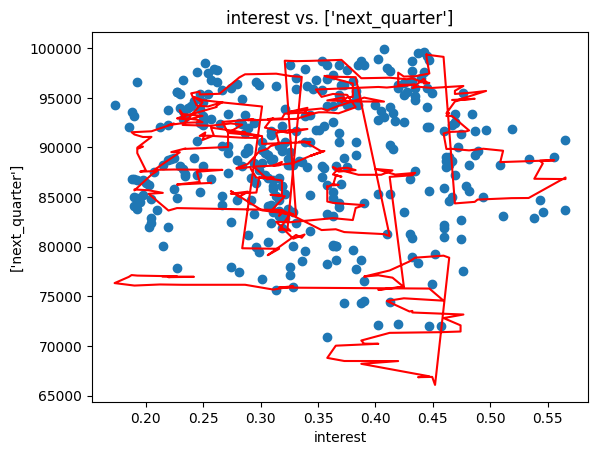

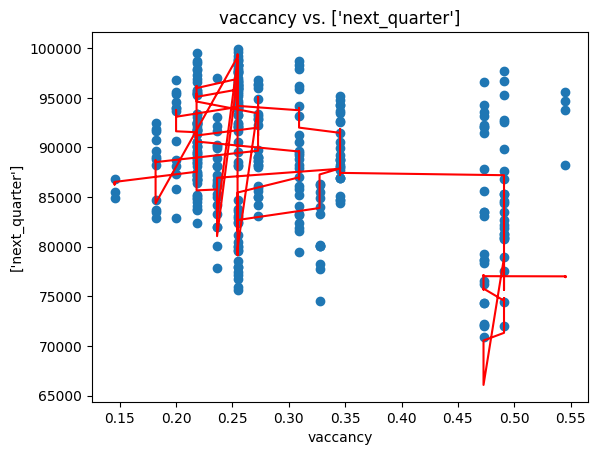

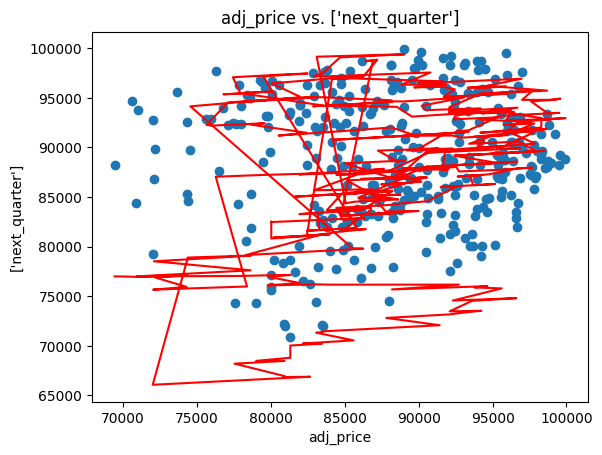

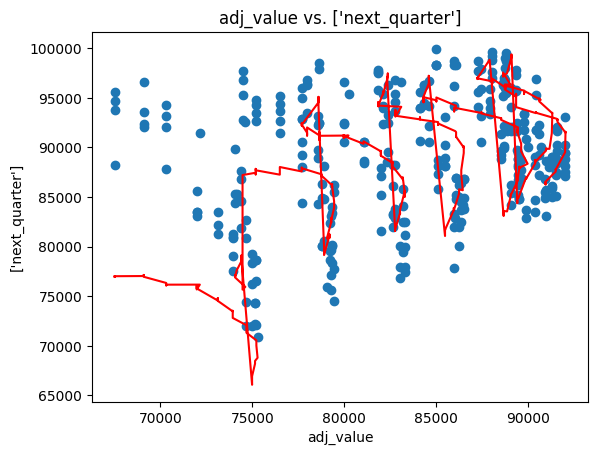

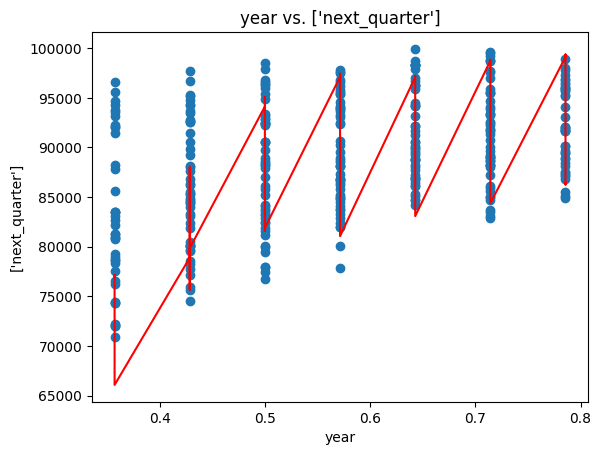

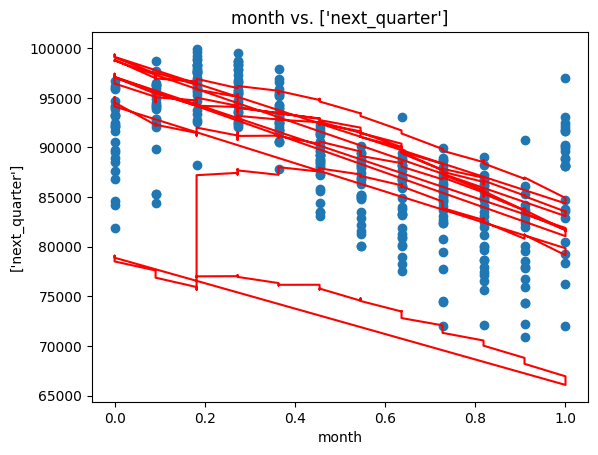

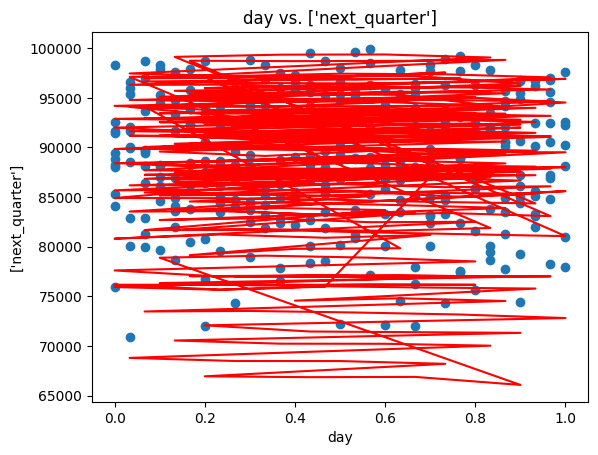

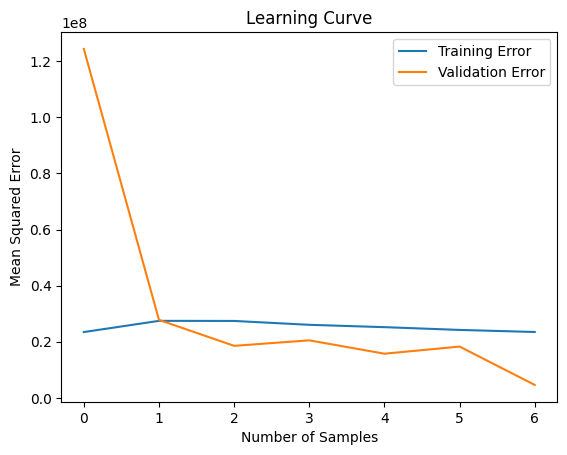

In [9]:
# linear regression 
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
param_grid = {'copy_X': [True, False], 'fit_intercept': [True, False], 'n_jobs': [-1, None], 'positive': [True, False]}

backtest(lr_model, train_data, predictors, target, param_grid)

KNN model training and hyperparameter tuning

MSE:  68146861.40584347
MAE:  6697.8772745555025
R-squared:  -0.7132703271792076
Training time: 0.0009998934609549387
Best parameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
Best R-squared: 0.33920776875207836
Best MSE: 6503969.513683878
Best MAE: 2020.5639845755836


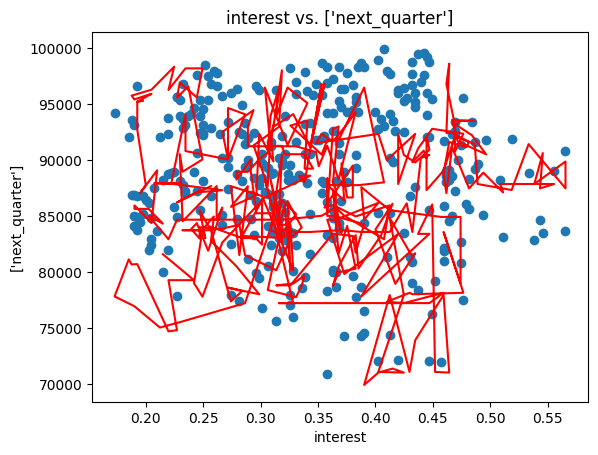

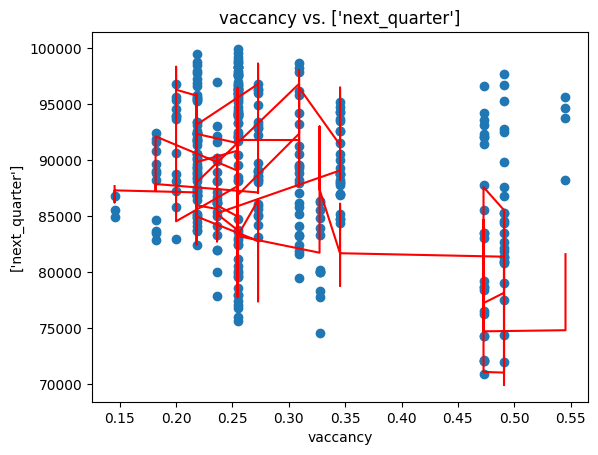

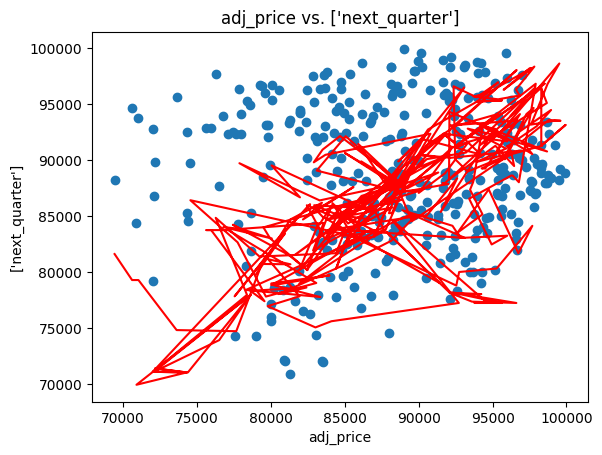

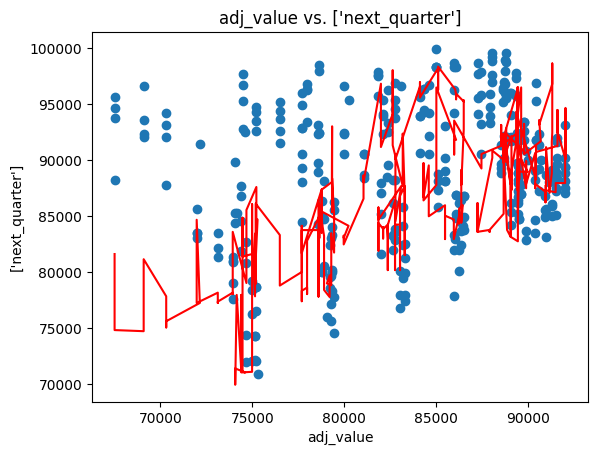

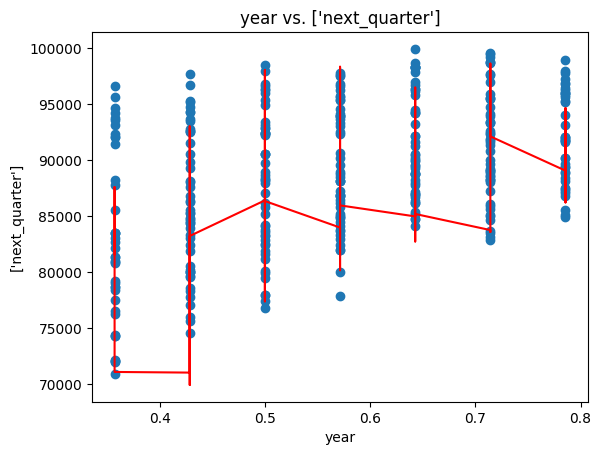

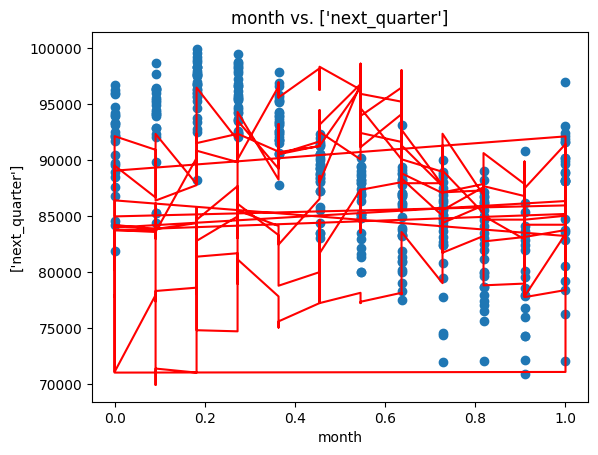

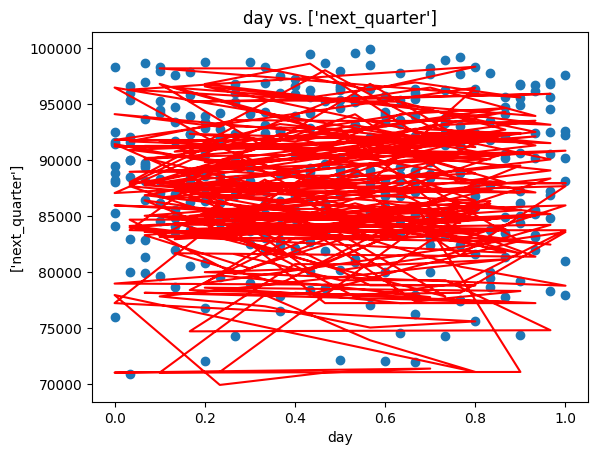

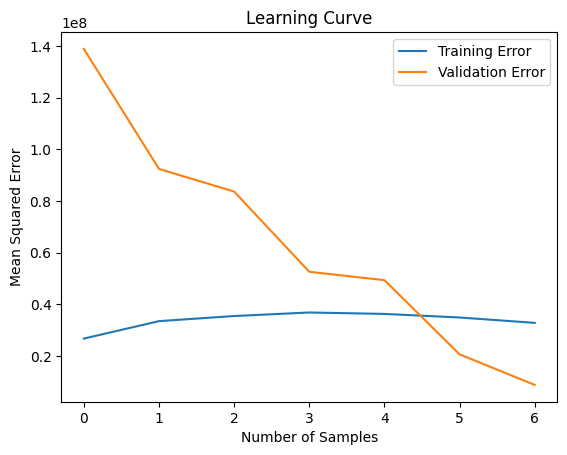

In [10]:
#KNN
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=10)

param_grid = {
    'n_neighbors': [5, 10, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30],
    'metric': ['euclidean', 'manhattan']
}

backtest(knn_model, train_data, predictors, target, param_grid)

Neural network model training and hyperparameter tuning

In [11]:
from keras.models import Sequential
from keras.layers import Dense

nn_model = Sequential()

# Add layers to the neural network - inputshape is 7 as 7 input columns
nn_model.add(Dense(64, activation='relu', input_shape=(7,)))
nn_model.add(Dense(1))
nn_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

backtest(nn_model, train_data, predictors, target)

# Define hyperparameters to test
param_grid = {
    'num_hidden_layers': [1, 2, 3],
    'hidden_layer_size': [32, 64, 128],
    'activation': ['relu', 'sigmoid', 'tanh']
}

# Define base model
def create_model(num_hidden_layers=1, hidden_layer_size=64, activation='relu'):
    nn_model = Sequential()
    nn_model.add(Dense(hidden_layer_size, activation=activation, input_shape=(7,)))
    for i in range(num_hidden_layers - 1):
        nn_model.add(Dense(hidden_layer_size, activation=activation))
    nn_model.add(Dense(1))
    nn_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return nn_model

# Loop through hyperparameters and evaluate model for each set of hyperparameters
best_score = float('-inf')

for num_hidden_layers in param_grid['num_hidden_layers']:
    for hidden_layer_size in param_grid['hidden_layer_size']:
        for activation in param_grid['activation']:

            #create model 
            nn_model = create_model(num_hidden_layers=num_hidden_layers, hidden_layer_size=hidden_layer_size, activation=activation)

            all_preds=[]
            training_times = []
            for i in range(START, train_data.shape[0], STEP):
                train = train_data.iloc[:i]
                test = train_data.iloc[i: (i+STEP)]
                response = predict(nn_model,train,test,predictors,target)
                all_preds.append(response[0])
                training_times.append(response[1])

            preds = np.concatenate(all_preds)
            training_time = np.mean(training_times)

            mse = mean_squared_error(train_data.iloc[START:][target], preds)
            mae = mean_absolute_error(train_data.iloc[START:][target], preds) # amount of dollars off from prediction
            score = r2_score(train_data.iloc[START:][target], preds)

            if score > best_score:
                best_score = score
                best_mse = mse
                best_mae = mae
                best_params = {'num_hidden_layers': num_hidden_layers, 'hidden_layer_size': hidden_layer_size, 'activation': activation}

print("Best parameters:", best_params)
print("Best R-squared:", best_score)
print("Best MSE:", best_mse)
print("Best MAE:", best_mae)

SyntaxError: invalid syntax (pywrap_tensorflow_internal.py, line 114)

Final Model Testing

- final test based on the test set the model hasnt seen yet
- will initialize the models with the best hyperparameters and train like normal and then will test on the final set. 


In [12]:
import joblib
import os

#linear regression 
best_lr_model = LinearRegression()
best_lr_model.set_params(copy_X=True, fit_intercept=True, n_jobs=-1, positive=False)

#training best lr model
for i in range(START, train_data.shape[0], STEP):
    train = train_data.iloc[:i]
    test = train_data.iloc[i: (i+STEP)]
    response = predict(best_lr_model,train,test,predictors,target)

#get prediction for test from best lr model
preds = best_lr_model.predict(test_data[predictors])
mse = mean_squared_error(test_data.iloc[0:][target], preds)
mae = mean_absolute_error(test_data.iloc[0:][target], preds) # amount of dollars off from prediction
r2 = r2_score(test_data.iloc[0:][target], preds)

# get size of model 
joblib.dump(best_lr_model, 'best_lr_model.joblib')
best_lr_model_size = os.path.getsize('best_lr_model.joblib')
print("Metrics from best Linear regression model")
print("MSE: ", mse)
print("MAE: ", mae)
print("R-squared: ", r2) # want as close to 1 as possible - indicates 
print("Model size:", best_lr_model_size, "bytes")
print()


#knn
best_knn_model = KNeighborsRegressor(n_neighbors=10)
best_knn_model.set_params(n_neighbors=15, weights='uniform', algorithm='auto', leaf_size=10, p=1, metric='euclidean')

#train model using backtesting
for i in range(START, train_data.shape[0], STEP):
    train = train_data.iloc[:i]
    test = train_data.iloc[i: (i+STEP)]
    response = predict(best_knn_model,train,test,predictors,target)

#get prediction for test
preds = best_knn_model.predict(test_data[predictors])
mse = mean_squared_error(test_data.iloc[0:][target], preds)
mae = mean_absolute_error(test_data.iloc[0:][target], preds) # amount of dollars off from prediction
r2 = r2_score(test_data.iloc[0:][target], preds)

# get size of model 
joblib.dump(best_knn_model, 'best_knn_model.joblib')
best_knn_model_size = os.path.getsize('best_knn_model.joblib')
print("Metrics from best KNN model")
print("MSE: ", mse)
print("MAE: ", mae)
print("R-squared: ", r2) # want as close to 1 as possible - indicates 
print("Model size:", best_knn_model_size, "bytes")
print()

# neural network model using best hyper parameters
best_hidden_layer_size = 128
best_num_hidden_layers = 3
best_activation = 'relu'
best_nn_model = Sequential()
best_nn_model.add(Dense(best_hidden_layer_size, activation=best_activation, input_shape=(7,)))
for i in range(best_num_hidden_layers - 1):
  best_nn_model.add(Dense(best_hidden_layer_size, activation=best_activation))
  best_nn_model.add(Dense(1))
  best_nn_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

#train model using backtesting for neural network
for i in range(START, train_data.shape[0], STEP):
    train = train_data.iloc[:i]
    test = train_data.iloc[i: (i+STEP)]
    response = predict(best_nn_model,train,test,predictors,target)

#get prediction for test
preds = best_nn_model.predict(test_data[predictors])
mse = mean_squared_error(test_data.iloc[0:][target], preds)
mae = mean_absolute_error(test_data.iloc[0:][target], preds) # amount of dollars off from prediction
r2 = r2_score(test_data.iloc[0:][target], preds)

# get size of model 
joblib.dump(best_nn_model, 'best_nn_model.joblib')
best_nn_model_size = os.path.getsize('best_nn_model.joblib')
print("Metrics from best neural network model")
print("MSE: ", mse)
print("MAE: ", mae)
print("R-squared: ", r2) # want as close to 1 as possible - indicates 
print("Model size:", best_nn_model_size, "bytes")



Metrics from best Linear regression model
MSE:  38142481.5864159
MAE:  5089.312278685924
R-squared:  -0.25924733771294806
Model size: 1055 bytes

Metrics from best KNN model
MSE:  53815685.503942594
MAE:  6417.155178962315
R-squared:  -0.7766871970430913
Model size: 84022 bytes



NameError: name 'Sequential' is not defined